**Graph Network Analysis**

**Get Packages**

In [17]:
# matplotlib ipynb widget
%matplotlib widget

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot, plot
import networkx as nx

import seaborn as sns
import matplotlib.colors as mc
import matplotlib.pyplot as plt

# Run this line if you are in a Jupyter Notebook environment
init_notebook_mode(connected=True)

# define paths for data and output
paths = {"base": "C://Users//avonl//OneDrive//Work//Research//projects//2023 - FRESH//code//FRESH//", 
         "alex": "alex//", 
         "data": "data//", 
         "tempfigs": "figs",
         "finalfigs": "figures//" 
        }

**load CSV file and clean data**

In [18]:
# loads csv to pandas dataframe
df = pd.read_csv(paths["base"]+paths["data"]+"FreshData.csv", encoding='utf-16', delimiter='\t')

# unifies NaNs: Replace all "NaN" values in df with "nan"
df = df.replace(np.nan, 'nan', regex=True)

# specific for this analysis: replace all "NaN"s in df with "Unknown"
df = df.replace('nan', 'Unknown', regex=True)

**Select and Prepare Data for Signal Analysis**

In [19]:
# selection of columns to keep for signal analysis
columns_sig = ['Study', 'ID', 'Toolbox used', \
           'Quality/Pruning: Method','Motion Artifact Method', \
           'Resample/Downsample (Hz)','Filtering Coding', \
           'Removal of the Global Signals during Preprocessing', \
           'Non-GLM: Method', 'GLM: Method', 'GLM: HRF Regressor', \
           'GLM: Other Regressors', 'Block Averaging: Modifiers']
df_siganalysis = df[columns_sig]

# rename 'Non-GLM Method' to 'Approach'
df_siganalysis = df_siganalysis.rename(columns={'Non-GLM: Method': 'Approach'})

# remove lines that contain "Not investigated" in column "Toolbox used"
df_siganalysis = df_siganalysis[~df_siganalysis['Toolbox used'].str.contains('Not investigated')]

# Removes "Custom: " substring from the entries in column "Toolbox used" of df_analysis and keeps only the rest.
df_siganalysis['Toolbox used'] = df_siganalysis['Toolbox used'].str.replace('Custom:', '')
df_siganalysis['Toolbox used'] = df_siganalysis['Toolbox used'].str.replace('Custom: ', '')

column_none = ['Quality/Pruning: Method', 'Motion Artifact Method', \
    'Resample/Downsample (Hz)', 'Filtering Coding']
none_txt = ['No Pruning', 'No Artifact Removal', 'No Resampling', 'No Filtering']
# rename entries in columns indicated in column_none that contain an "Unknown" to the corresponding entry in none_txt
for i in range(len(column_none)):
    df_siganalysis[column_none[i]] = df_siganalysis[column_none[i]].replace('Unknown', none_txt[i], regex=True)

    
# rename "Other" entries in column 'Quality/Pruning: Method' to 'Other Pruning Method'
df_siganalysis['Quality/Pruning: Method'] = df_siganalysis['Quality/Pruning: Method'].replace('Other', 'Other Pruning Method', regex=True)
# In "Quality/Pruning: Method" rename "Manual Selection" and "Visual Inspection of Time Domain" to "Manual Pruning"
df_siganalysis['Quality/Pruning: Method'] = df_siganalysis['Quality/Pruning: Method'].replace('Manual Selection', 'Manual Pruning', regex=True)
df_siganalysis['Quality/Pruning: Method'] = df_siganalysis['Quality/Pruning: Method'].replace('Visual Inspection of Time Domain', 'Manual Pruning', regex=True)

# rename "Other" entries in column 'Motion Artifact Method' to 'Other Removal Method'
df_siganalysis['Motion Artifact Method'] = df_siganalysis['Motion Artifact Method'].replace('Other', 'Other Removal Method', regex=True)
# rename "Rejection" entries in column 'Motion Artifact Method' to 'Trial Rejection'
df_siganalysis['Motion Artifact Method'] = df_siganalysis['Motion Artifact Method'].replace('Rejection', 'Trial Rejection', regex=True)

# rename "Unknown"" entries in column 'Removal of the Global Signals during Preprocessing' to 'No Removal''
df_siganalysis['Removal of the Global Signals during Preprocessing'] = df_siganalysis['Removal of the Global Signals during Preprocessing'].replace('No', 'No Removal', regex=True)
# rename "No" entries in column 'Removal of the Global Signals during Preprocessing' to 'No Removal''
df_siganalysis['Removal of the Global Signals during Preprocessing'] = df_siganalysis['Removal of the Global Signals during Preprocessing'].replace('Unknown', 'No Removal', regex=True)
# rename "Other" entries in column 'Removal of the Global Signals during Preprocessing' to 'Other Removal''
df_siganalysis['Removal of the Global Signals during Preprocessing'] = df_siganalysis['Removal of the Global Signals during Preprocessing'].replace('Other', 'Other Method', regex=True)

# rename "Unknown" entries in column 'GLM: Method' to 'Unknown Method'
df_siganalysis['GLM: Method'] = df_siganalysis['GLM: Method'].replace('Unknown', 'Unknown Method', regex=True)
# rename "Default" entries in column 'GLM: Method' to 'Default Method'
df_siganalysis['GLM: Method'] = df_siganalysis['GLM: Method'].replace('Default', 'Default Method', regex=True)
# replace any entry in column "GLM: Method" that contains the string "AR-IRLS" completely with only "AR-IRLS"
df_siganalysis['GLM: Method'] = df_siganalysis['GLM: Method'].replace('AR-IRLS.*', 'AR-IRLS', regex=True)
# rename "Other" entries in column 'GLM: Method' to 'Other Method'
df_siganalysis['GLM: Method'] = df_siganalysis['GLM: Method'].replace('Other', 'Other Solver', regex=True)


# rename "Unknown" entries in column 'GLM: HRF Regressor' to 'Unknown HRF Regressor'
df_siganalysis['GLM: HRF Regressor'] = df_siganalysis['GLM: HRF Regressor'].replace('Unknown', 'Unknown HRF Regressor', regex=True)
# rename "Default" entries in column 'GLM: HRF Regressor' to 'Default HRF Regressor'
df_siganalysis['GLM: HRF Regressor'] = df_siganalysis['GLM: HRF Regressor'].replace('Default', 'Default HRF Regressor', regex=True)

# rename "Unknown" entries and "Other" entries in column 'GLM: Other Regressors' to 'Unknown Other Regressors'
df_siganalysis['GLM: Other Regressors'] = df_siganalysis['GLM: Other Regressors'].replace('Unknown', 'Unknown Additional Regressors', regex=True)
df_siganalysis['GLM: Other Regressors'] = df_siganalysis['GLM: Other Regressors'].replace('Other', 'Unknown Additional Regressors', regex=True)


# for all rows that contain "Block Averaging" or "Other" in column "Approach"... 
rw_idx = df_siganalysis.loc[df_siganalysis['Approach'].str.contains('Block Averaging')].index
rw_idx = rw_idx.append(df_siganalysis.loc[df_siganalysis['Approach'].str.contains('Other')].index)


# replace the the cell in column "GLM: Method" with the corresponding cell from "Block Averaging: Modifiers" for these rows
df_siganalysis.loc[rw_idx, 'GLM: Method'] = df_siganalysis.loc[rw_idx, 'Block Averaging: Modifiers']
# for these rows, replace "Unknown" with "No Correction"
df_siganalysis.loc[rw_idx, 'GLM: Method'] = df_siganalysis.loc[rw_idx, 'GLM: Method'].replace('Unknown', 'No Correction', regex=True)

# ...replace "Unknown HRF Regressor" in column "GLM: HRF Regressor" with an empty string
df_siganalysis.loc[rw_idx, 'GLM: HRF Regressor'] = df_siganalysis.loc[rw_idx, 'GLM: HRF Regressor'].replace('Unknown HRF Regressor', '', regex=True)
# ...replace "Unknown Other Regressor" in column "GLM: Other Regressors" with an empty string
df_siganalysis.loc[rw_idx, 'GLM: Other Regressors'] = df_siganalysis.loc[rw_idx, 'GLM: Other Regressors'].replace('Unknown Additional Regressors', '', regex=True)

# delete column "Block Averaging: Modifiers"
df_siganalysis = df_siganalysis.drop(columns=['Block Averaging: Modifiers'])

**Create Graph Network**

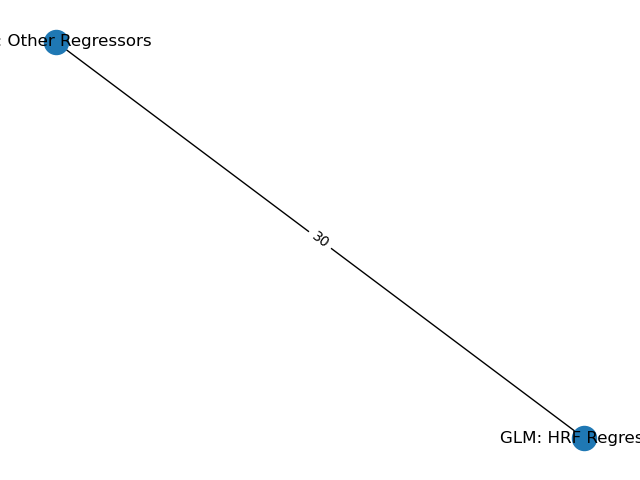